In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Create data from power spectrum

This function is set up to create a single Lorentzian peak and will be used to create several "modes". The mode height and central frequency will be set by the factor $i$ relative to the other input parameters. The mode height will be reduced by a factor $i^2$, and the central freuqency will be shifted by a factor $i$.

In [2]:
def single_lorentzian(x, x_0, A, width, i):
    model = ((2*A**2 / (np.pi*width*i**2)) / (1 + (2*(x-i*x_0) / width)**2))
    return model

Here we create and plot the power spectrum of the artificial data, to have a peak at the 27-rotation period ($\nu_0$) with 4 harmonics $n \, \nu_0$ for n in range 2-5.

Power = 215467339645.4018


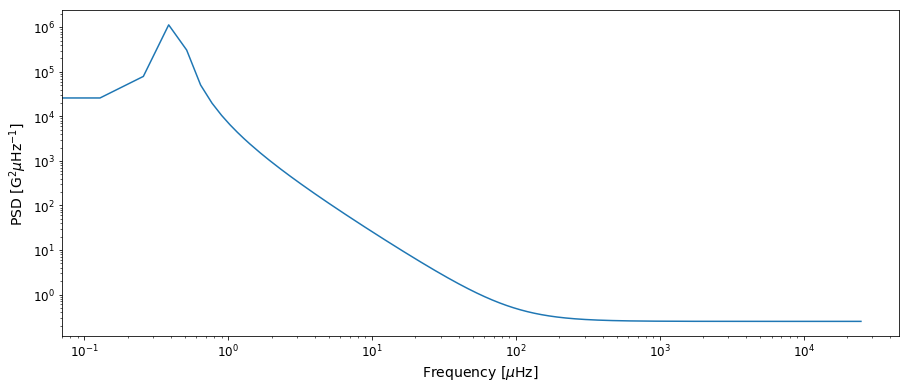

Peak at nu_0 = 0.3858 muHz


In [3]:
dx = 0.1286 # Resolution 0.1286 muHz (90 days ~= 3 mths)
x = np.arange(0, (1*1e6/(40)), dx) # Nyquist = 40 s 
x_0 = (1e6/(3600*24*27)) # Central frequency of fundamental peak (i.e. 27-day peak ~= 0.43 muHz)
A = 700 # Amplitude of fundamental peak [G]
width = 0.03 # Width [muHz]

powers = [single_lorentzian(x, x_0, A, width, i) for i in np.arange(1,2)] # Create peak(s)
powers = np.sum(powers, axis=0) # Sum single peak(s) together into one power spectrum
print("Power = %s"%(np.sum(powers * dx * 1e6)))
powers = powers + 0.25 # Add a bkgnd level of 1

sigma = 0
tau = 0.004
#powers = powers + (4*sigma**2*tau)/(1 + (2*np.pi*x*tau)**2)

# Plot peaks
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD [G$^2$$\mu$Hz$^{-1}$]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, powers)
plt.show()

print("Peak at nu_0 = %s muHz"%x[np.argmax(powers)])

Now we need to convert the signal from PSD into amplitude ($A(f(k))$): $A(f(k)) \, = \, \sqrt{2 \,\mathrm{PSD}}$

BUT - first need to go from PSD in units [G$^2$$\mu$Hz$^{-1}$] into [G$^2$]

Then to convert from amplitude to the frequency domain signal ($Z(f(k))$): $Z(f(k)) \, = \, A(f(k)) \, e^{i \phi(f(k)))}$, where $\phi(f(k))$ is some random phase supplied to the signal between $0$ and $2\pi$.

In [4]:
#powers *= dx*1e6 # Change into units [G^2]

Time series length: 194402
Time series length: 194402
(194402,) 194402 194402
[4.19440076 4.67790448 3.60884639 ... 4.06549875 3.94414931 4.91852944]


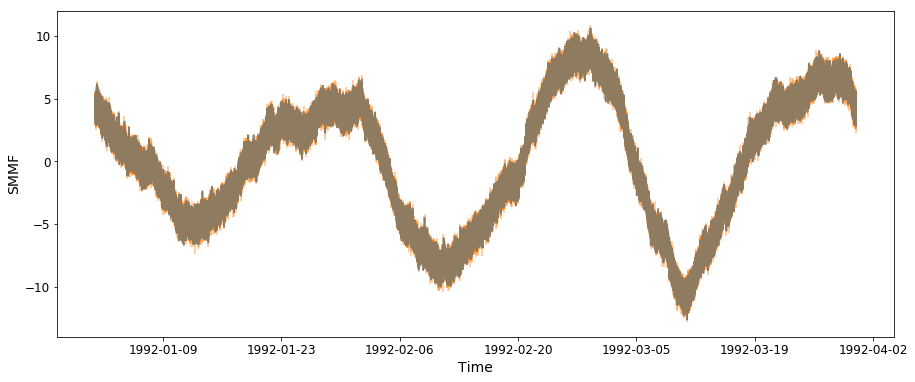

Time-series real component variance: 25.504004662496456


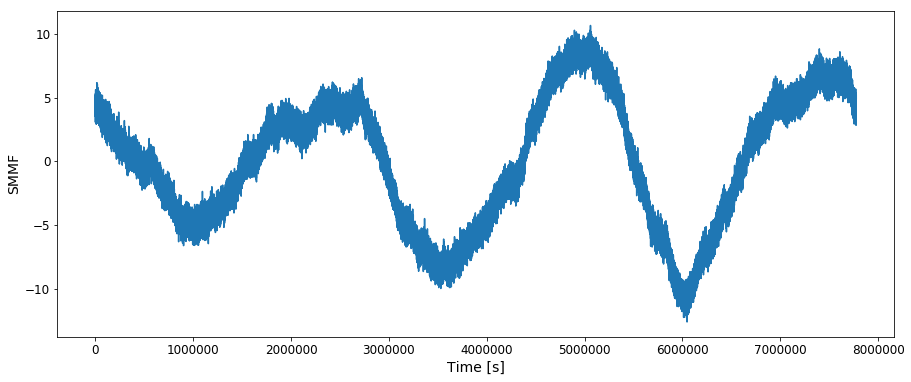

In [5]:
# This is overtaken by the method below
amplitudes = np.sqrt(powers) # Compute amplitudes from powers
phases = np.random.uniform(0, 2*np.pi, len(amplitudes)) # Generate random phases
freq_sigs = [a*np.exp(1j*p) for a,p in zip (amplitudes, phases)] # Conversion to frequency domain signal
time_series = np.fft.ifft(freq_sigs) # Compute discrete FFT (probably not correct!)
t = np.arange(len(time_series)) # Time array [40 s]
ts = t * (40) # Time array [s]
print('Time series length: %s'%(len(time_series)))


noise = np.fft.fft(np.random.randn(len(powers)))
amp_spec = noise * 1 * np.sqrt(powers)
time_series = np.fft.irfft(amp_spec, n=len(powers))
t = np.arange(len(time_series)) # Time array [40 s]
ts = t * (40) # Time array [s]
print('Time series length: %s'%(len(time_series)))
print(noise.shape, len(powers), len(time_series))
print(time_series)
# Put the time series into a pandas DataFramd with the index as time since 01/01/1992
df = pd.DataFrame({'SMMF':time_series.real}, 
                      index=[datetime.datetime(1992,1,1) + datetime.timedelta(seconds=int(ti)) for ti in ts])

# Plot time series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(df.index.values, df['SMMF'])

yerr = np.random.normal(0, 0.25, len(time_series))
ax.errorbar(df.index.values, df['SMMF'], abs(yerr), alpha=0.5)
plt.show()

# Plot time series
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)
ax.plot(ts, df['SMMF'])


print('Time-series real component variance: %s'%(np.std(time_series.real)**2))

Now we should re-do the FFT to ensure that the PSD comes out the same as what we started with.

Begin FFT...
Pre-mask times length: 194402
Fill is: 1.0
Post-mask times length: 194402


/home/exr007/.local/lib/python3.5/site-packages/astropy/stats/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


TS_var: 25.504004662496456
FD: 25.504004662496463


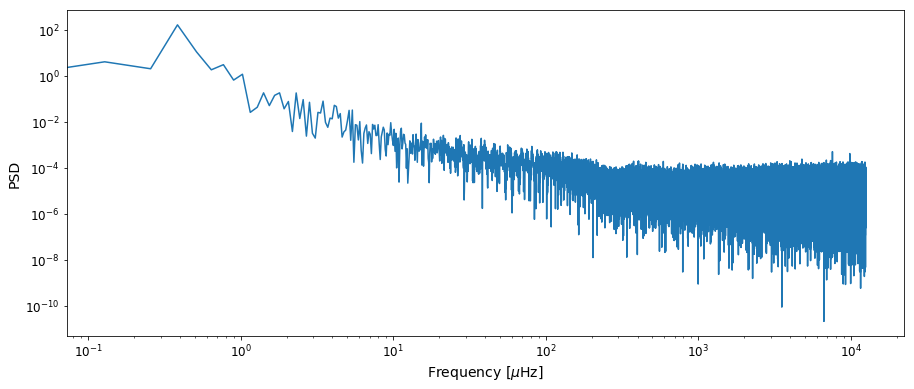

Time-series variance: 25.504004662496456
Peak at nu_0 = 0.385798500015432 muHz


In [6]:
import timeseries_FFT

def FFT(start, end, data = None, oversample = False, plot=False):
    print('Begin FFT...')
    # data = self.Vn_df[0] # set FFT data
    data = data
    error = data*0.0001

    f = timeseries_FFT.timeseries_FFT_plot(data, error, start, end, 'SMMF [G]', 'PSD [$G^2$$\mu$Hz$^{-1}$]', maj_tick = .5, min_tick=.05)
    freqs, power, times = f.FT_data()
    if plot == True:
        f.make_plot()
    return freqs, power, times

# Re-compute the power spectrum
freqs, power, times = FFT(start = pd.to_datetime(df.index.values[0]), end = pd.to_datetime(df.index.values[-1]), data = df['SMMF'], plot=False, oversample=False)

# Plot power re-calculated power spectrum
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(freqs, power)
plt.show()

print('Time-series variance: %s'%(np.std(df['SMMF'])**2))
print("Peak at nu_0 = %s muHz"%freqs[np.argmax(power)])

This looks ok... the y-axis values are different to those used during the input which should be checked... it could be a mixture of units/mistakes in going from PSD->AMP->TS/general errors that have caused this difference.

The new nyquist is half the original frequency grid, due to the way that I set up the frequency grid initially, but expect this to be $\frac{1}{2 dT}$, whdre $dT$ is the sampling in the time domain.

Now we remove some of the data, to make the data set more comparable to real BiSON data with a fill of around 0.15

32400
[3.80224548 4.09836094 4.90668315 ... 4.82206147 4.54591312 3.84231007]
Fill is: 0.14814662400592588


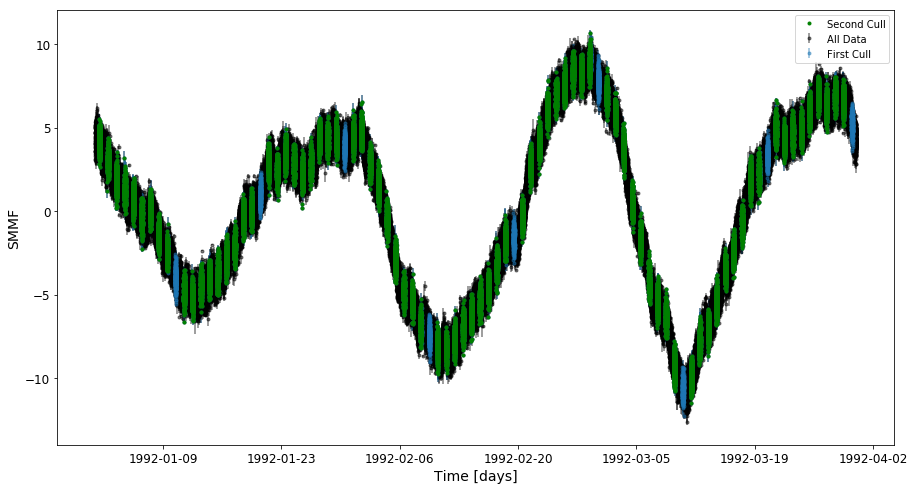

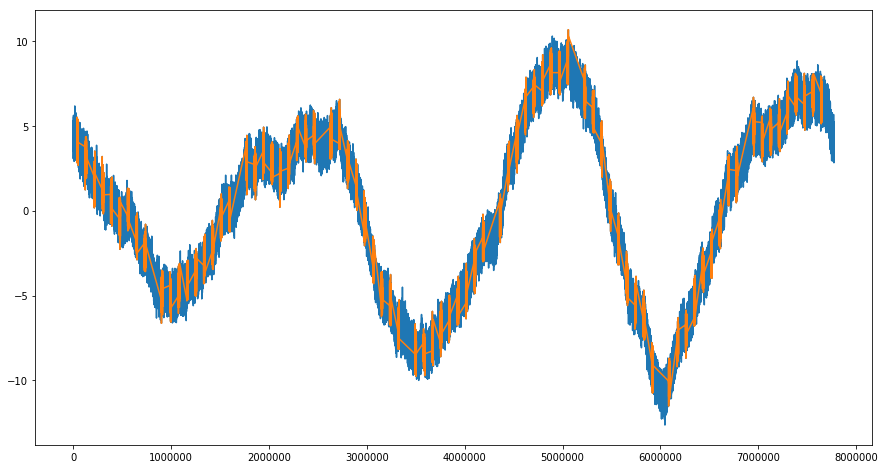

In [7]:
start = 900 # skip first 900
take = 360 # retain 100 points at a time
skip = 1800 # skip every 2060 points at a time
indices = np.concatenate([np.arange(i, i + take) for i in range(start, len(df), take + skip)])
print(len(indices))
#print(tst_ary[indices])
t2 = df['SMMF'].index.values[indices]
ts2 = ts[indices]
df2 = df['SMMF'].values[indices]
yerr2 = yerr[indices]
print(df2)

# Repeat again to remove a couple of days
start = 0 
take = 3200 # keep 500 points
skip = 400 # remove 100 points
indices2 = np.concatenate([np.arange(i, i + take) for i in range(start, len(df2), take + skip)])
print('Fill is: %s'%(len(df2[indices2])/len(df)))

df_SMMF = pd.DataFrame({'SMMF':df2[indices2], 'ts':ts2[indices2], 'yerr':yerr2[indices2]}, index=t2[indices2])

fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)

ax.errorbar(df.index.values, df['SMMF'].values, yerr=yerr, fmt=".k", alpha= 0.5, capsize=0, label='All Data', zorder=2)
ax.errorbar(df.index.values[indices], df['SMMF'].values[indices], yerr=yerr[indices], alpha= 0.5, fmt=".", capsize=0, label='First Cull', zorder=2)
ax.plot(df_SMMF.index.values, df_SMMF['SMMF'], '.g', label='Second Cull', zorder=3)
plt.legend()

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(ts, df['SMMF'].values)
ax.plot(df_SMMF['ts'], df_SMMF['SMMF'])

In [8]:
"""
IGNORE - was testing to see what the removal of the power at peak freq looks like

import scipy

def fit_sin(TS_df, FFT_df, times, fit_freq):
    wt = 2*np.pi*fit_freq*times       
    def trigfunc2(wt, A, B, C, X, Y):
        return A * np.sin(wt + B) + X * np.cos(wt + Y) + C   
    def trigfunc(wt, A, B, C):
        return A * np.sin(wt + B) + C
    popt, pcov = scipy.optimize.curve_fit(trigfunc2, wt, TS_df)        
    return popt, pcov

peak_freq = 1.1573955e-6
res,cov = fit_sin(df_SMMF['SMMF'], None, df_SMMF['ts'], peak_freq)

after2 = df_SMMF['SMMF'].values - (res[2] + (res[0]*np.sin(2*np.pi*peak_freq*df_SMMF['ts'] + res[1])) + (res[3]*np.cos(2*np.pi*peak_freq*df_SMMF['ts'] + res[4])))

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_SMMF['ts'], df_SMMF['SMMF'])
ax.plot(df_SMMF['ts'], after)
#ax.plot(df_SMMF['ts'], after2)

fqs, pwr, tms = FFT(start = pd.to_datetime(df_SMMF.index.values[0]), end = pd.to_datetime(df_SMMF.index.values[-1]), data = after, plot=False, oversample=False)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(fqs, pwr)
ax.set_xscale('log')
ax.set_yscale('log')
"""

"\nIGNORE - was testing to see what the removal of the power at peak freq looks like\n\nimport scipy\n\ndef fit_sin(TS_df, FFT_df, times, fit_freq):\n    wt = 2*np.pi*fit_freq*times       \n    def trigfunc2(wt, A, B, C, X, Y):\n        return A * np.sin(wt + B) + X * np.cos(wt + Y) + C   \n    def trigfunc(wt, A, B, C):\n        return A * np.sin(wt + B) + C\n    popt, pcov = scipy.optimize.curve_fit(trigfunc2, wt, TS_df)        \n    return popt, pcov\n\npeak_freq = 1.1573955e-6\nres,cov = fit_sin(df_SMMF['SMMF'], None, df_SMMF['ts'], peak_freq)\n\nafter2 = df_SMMF['SMMF'].values - (res[2] + (res[0]*np.sin(2*np.pi*peak_freq*df_SMMF['ts'] + res[1])) + (res[3]*np.cos(2*np.pi*peak_freq*df_SMMF['ts'] + res[4])))\n\nfig, ax = plt.subplots(figsize=(15,8))\nax.plot(df_SMMF['ts'], df_SMMF['SMMF'])\nax.plot(df_SMMF['ts'], after)\n#ax.plot(df_SMMF['ts'], after2)\n\nfqs, pwr, tms = FFT(start = pd.to_datetime(df_SMMF.index.values[0]), end = pd.to_datetime(df_SMMF.index.values[-1]), data = after,

## Celerite model

Now we will try to model the time-series using a GP.

Note that we assume Q-factor: $Q \, = \, \frac{\nu_0}{\Gamma}$

In [9]:
import celerite
from celerite import terms
from celerite.modeling import Model

"""
# A real-term
bounds = dict(log_a=(0, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log(10), log_c=-np.log(1.0), bounds=bounds)


# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = 0.01
#bounds = dict(log_S0=(-15, 20), log_Q=(-15, 15), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term
"""

# Jitter Term
bounds = dict(log_sigma=(-15, 15))
kernel = terms.JitterTerm(log_sigma=np.log(0.5), bounds=bounds)

# A periodic component for fundamental harmonic peak
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-10, 20), log_Q=(-10, 5), log_omega0=(-13.0, -12.5))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / (27.0*3600*24))
#S0 = np.var(df.SMMF.values) / (w0 * Q) / 10
S0 = np.var(df_SMMF['SMMF']) / (w0 * Q) / 1.0
print(np.log(S0), np.log(Q), np.log(w0))
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


# A 2nd periodic component for 2nd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-10, 20), log_Q=(-10, 5), log_omega0=(-12.5, -5))
Q = 1
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / (13.5*3600*24))
S0 = np.var(df_SMMF['SMMF']) / (w0 * Q) / 1.0
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
"""
# A 2nd periodic component for 3rd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-5, 5), log_omega0=(-0.5, -0.2))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 3 * 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# A 2nd periodic component for 4th harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-15, 15), log_Q=(-5, 5), log_omega0=(-0.2, 0))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 4 * 2.0 * np.pi * (1.0 / 27.0)
S0 = np.var(df.SMMF.values) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

"""

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "P")

    def get_value(self, t):
        return self.A * np.sin(2.0 * np.pi * t / self.P)
    
# Create and compute GP
gp = celerite.GP(kernel, mean=np.mean(df_SMMF.SMMF.values), fit_mean=False)
gp.compute(df_SMMF.ts.values, df_SMMF.yerr.values)  # Always need to call compute once
print("Initial log likelihood: %.6f"%(gp.log_likelihood(df_SMMF['SMMF'].values)))
print(gp.get_parameter_vector())

13.72608027585683 2.302585092994046 -12.82470275438713
Initial log likelihood: -21501.473882
[ -0.69314718  13.72608028   2.30258509 -12.82470275  15.33551819
   0.         -12.13155557]


Create likelihood function for emcee to work with

In [10]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    #if params[0] < 0:
    #    return -np.inf
    return gp.log_likelihood(df_SMMF['SMMF'].values) + lp

Run emcee on this

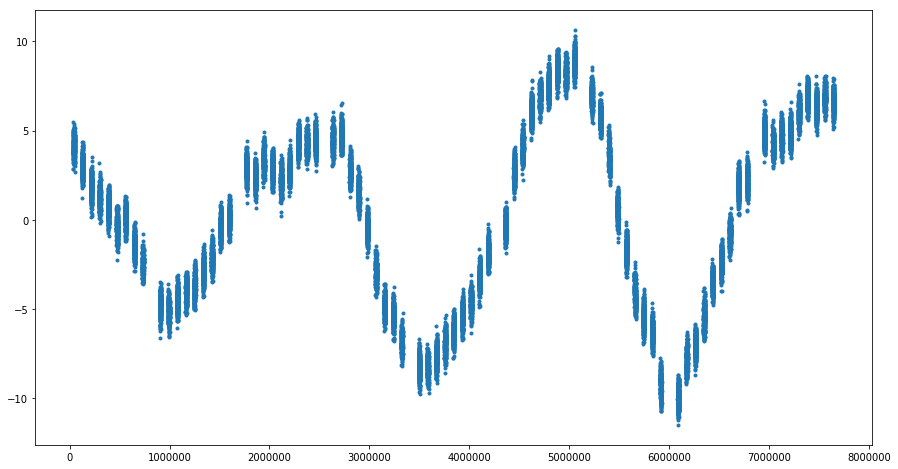

In [11]:
# Last plot of time-series before emcee

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_SMMF['ts'], df_SMMF['SMMF'], '.')

In [12]:
import emcee

initial = gp.get_parameter_vector()
print(initial)
print(log_probability(initial))

ndim, nwalkers = len(initial), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, a=4)

import time
start_time = time.time()

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 5000)
print("... elapsed_time = %.6f s"%(time.time() - start_time))

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 15000);

print("We're done here...")
print("... elapsed_time = %.6f s"%(time.time() - start_time))

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

print(gp.get_parameter_vector())

[ -0.69314718  13.72608028   2.30258509 -12.82470275  15.33551819
   0.         -12.13155557]
-21501.47388243855
Running burn-in...
... elapsed_time = 848.448187 s
Running production...
We're done here...
... elapsed_time = 3351.987691 s
Mean acceptance fraction: 0.208
[ -0.6921067   14.02011302   2.60475117 -12.87993372  12.31991815
  -5.87062119  -6.7404626 ]


(750000, 7)


Text(0.5,0,'Step Number')

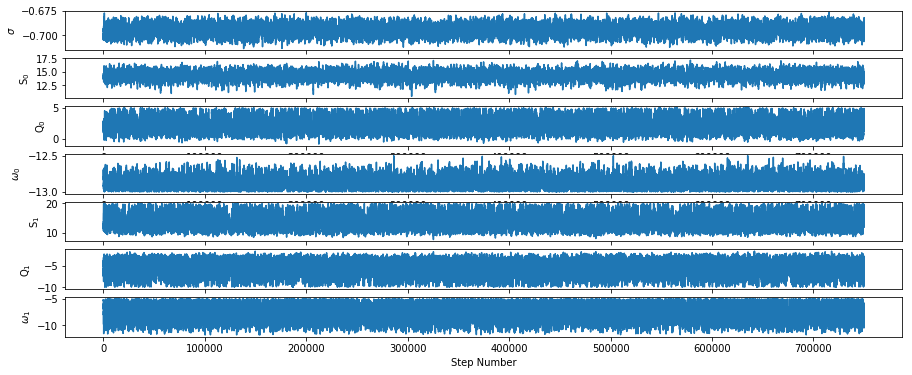

In [13]:
nparams = len(initial)
sam = sampler.flatchain
exp_sam = np.exp(sam)
print(np.shape(sam))
labels = ["$\\sigma$", "S$_0$", "Q$_0$", "$\\omega_0$", "S$_1$", "Q$_1$", "$\\omega_1$", "S$_2$", "Q$_2$", "$\\omega_2$", "S$_3$", "Q$_3$", "$\\omega_3$"]
fig, ax = plt.subplots(nparams, figsize=(15,6))
for i in range(nparams):
    ax[i].plot(sam[:, i])
    ax[i].set_ylabel(labels[i])
    
ax[-1].set_xlabel('Step Number')

Import and plot corner.

$\sigma$ units: TBC

$S_0$ units: TBC

$Q_0$ units: unitless

$\omega$ units: rad/day

$\sigma$= 4.99346e-01 (+2.19317e-03 / -2.13210e-03)
$\S_0$= 1.63129e+06 (+1.29322e+06 / -7.13092e+05)
$Q_0$= 7.33078e+00 (+1.57058e+01 / -4.06871e+00)
$\omega_0$= 2.56045e-06 rad/s (+1.84200e-07 / -1.56960e-07) rad/s
Period: 28.402 days (+1.741 / -2.043) days


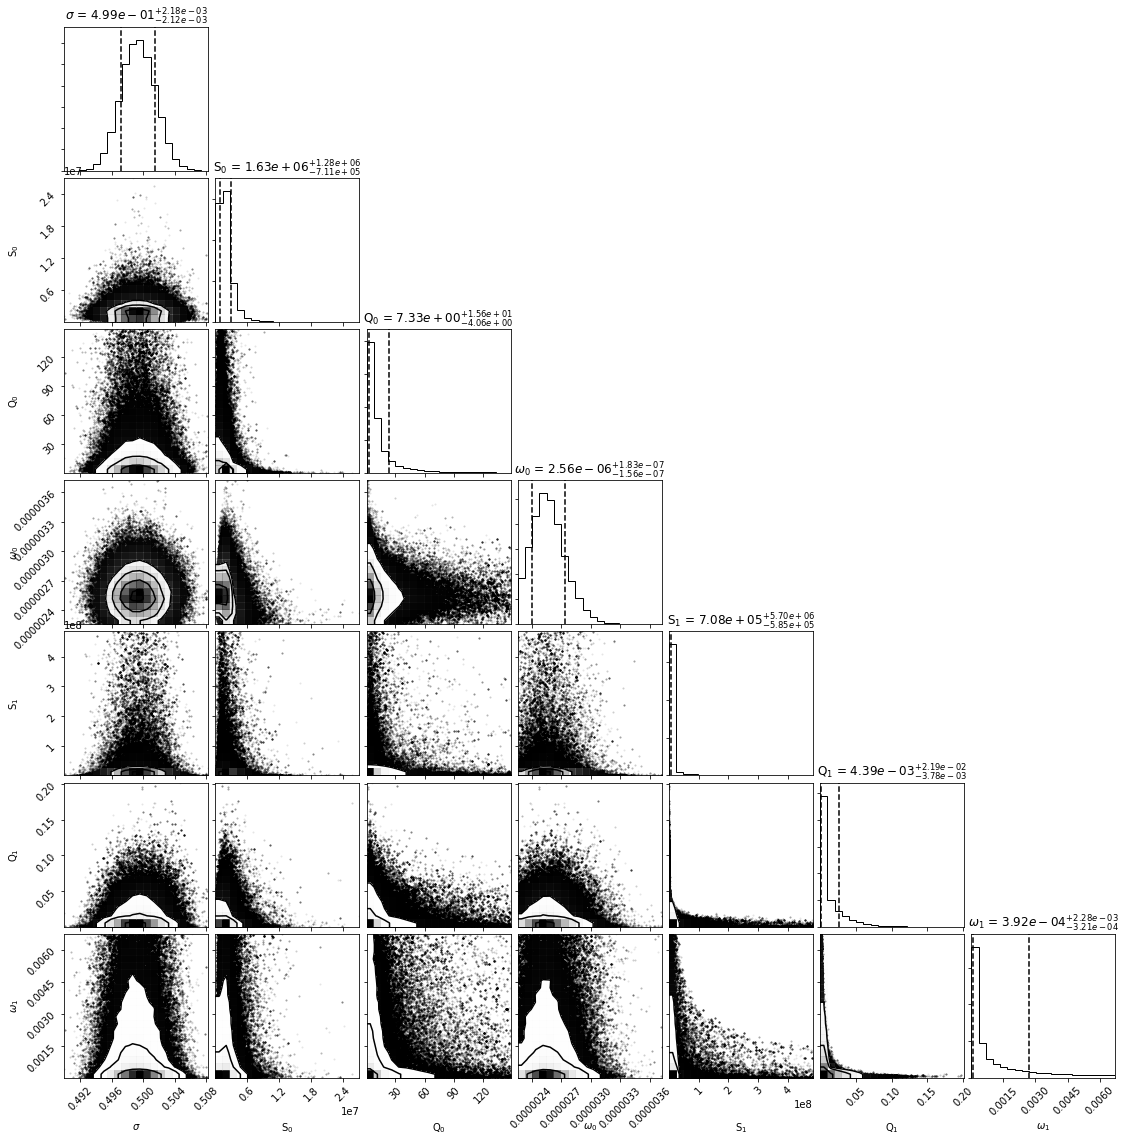

[5.00520512e-01 1.22703717e+06 1.35278588e+01 2.54868321e-06
 2.24115798e+05 2.82112033e-03 1.18210019e-03]


In [14]:
import corner

fit = np.percentile(exp_sam, 50, axis=0)
lower_std = abs(np.percentile(exp_sam, 50-34.13, axis=0) - fit)
upper_std = abs(np.percentile(exp_sam, 50+34.13, axis=0) - fit)

print("%s= %.5e (+%.5e / -%.5e)"%('$\sigma$', fit[0], upper_std[0], lower_std[0]))
print("%s= %.5e (+%.5e / -%.5e)"%('$\S_0$', fit[1], upper_std[1], lower_std[1]))
print("%s= %.5e (+%.5e / -%.5e)"%('$Q_0$', fit[2], upper_std[2], lower_std[2]))
print("%s= %.5e rad/s (+%.5e / -%.5e) rad/s"%('$\omega_0$', fit[3], upper_std[3], lower_std[3]))

prd = (1/(fit[3]/(2*np.pi)))/(24*3600)
prd_low = upper_std[3] * prd / fit[3] # use upp omega to get lower period (as inverse)
prd_upp = lower_std[3] * prd / fit[3] # use low omega to get upper period (as inverse)
print("Period: %.3f days (+%.3f / -%.3f) days"%(prd, prd_upp, prd_low))

corner.corner(exp_sam,
                show_titles = True,
                labels = ["$\\sigma$", "S$_0$", "Q$_0$", "$\\omega_0$", "S$_1$", "Q$_1$", "$\\omega_1$", "S$_2$", "Q$_2$", "$\\omega_2$", "S$_3$", "Q$_3$", "$\\omega_3$"],
                quantiles = [0.5-0.3413, 0.5+0.3413], 
                title_fmt='.2e')
plt.savefig('GP_test_corner.png', dpi=300)
plt.show()

print(np.exp(gp.get_parameter_vector()))
#print("Period: %.6e"%model.P)
#print("Amplitude: %.6e"%model.A)

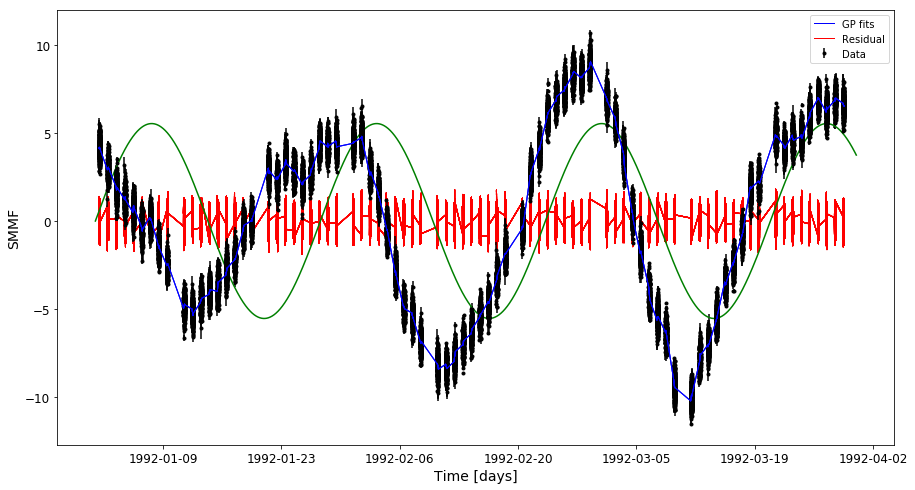

In [19]:
# Plot the data.
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Time [days]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)

ax.errorbar(df_SMMF.index.values, df_SMMF['SMMF'].values, yerr=df_SMMF['yerr'], fmt=".k", capsize=0, label='Data', zorder=2)

#lp = like(t, df['SMMF'].values, yerr)
# Plot GP samples.
#samples = sampler.flatchain
itn = 0
for s in sam[np.random.randint(len(sam), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(df_SMMF['SMMF'].values, df_SMMF['ts'], return_cov=False)
    if itn == 0:
        a = ax.plot(df_SMMF.index.values, mu, color='b', alpha=1, lw=1.0, label='GP fits', zorder=3)
        b = ax.plot(df_SMMF.index.values, df_SMMF['SMMF'].values - mu, color='r', alpha=1, lw=1.0, label='Residual', zorder=1)
        itn+=1
    else:
        a = ax.plot(df_SMMF.index.values, mu, color='b', alpha=0.1, lw=1.0, zorder=3)
        b = ax.plot(df_SMMF.index.values, df_SMMF['SMMF'].values - mu, color='r', alpha=1, lw=1.0, zorder=1)

ax.legend()

amp = np.sqrt(fit[1] * fit[2] * fit[3]) #sqrt(S0 * w0 * Q)
ax.plot(df.index.values, amp*np.sin(np.exp(gp.get_parameter_vector())[3]*ts), 'g', label='sinusoid at freq $\omega_0$')

#ax.plot(df.index.values, 5*np.sin(4.848E-6*ts))



No. kernel terms: 3


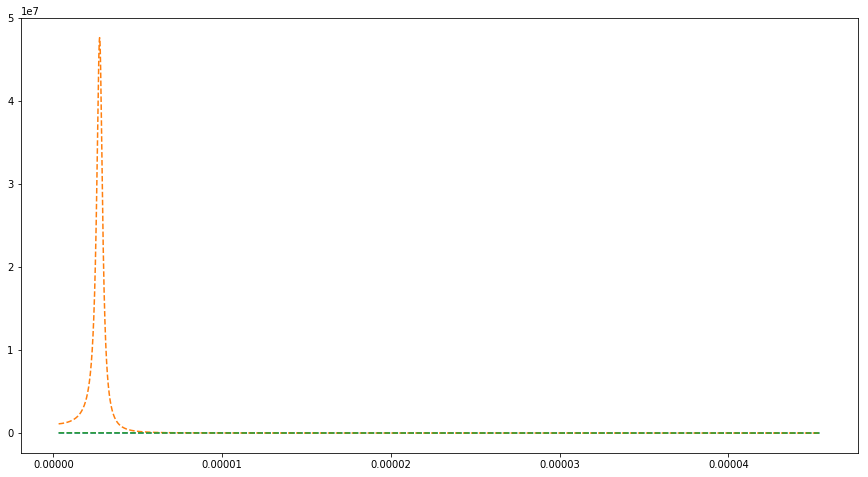

In [16]:
omega = np.exp(np.linspace(-15, -10, 5000))
psd = gp.kernel.get_psd(omega)
fig, ax = plt.subplots(figsize=(15,8))
print('No. kernel terms: %s'%len(gp.kernel.terms))
for k in gp.kernel.terms:
    ax.plot(omega, k.get_psd(omega), "--")

Now remove some of the data to make it more representative of real SMMF data

In [17]:
print(df_SMMF['ts'])
print(df_SMMF.index.values[-2] - df.index.values[0])

1992-01-01 10:00:00      36000
1992-01-01 10:00:40      36040
1992-01-01 10:01:20      36080
1992-01-01 10:02:00      36120
1992-01-01 10:02:40      36160
1992-01-01 10:03:20      36200
1992-01-01 10:04:00      36240
1992-01-01 10:04:40      36280
1992-01-01 10:05:20      36320
1992-01-01 10:06:00      36360
1992-01-01 10:06:40      36400
1992-01-01 10:07:20      36440
1992-01-01 10:08:00      36480
1992-01-01 10:08:40      36520
1992-01-01 10:09:20      36560
1992-01-01 10:10:00      36600
1992-01-01 10:10:40      36640
1992-01-01 10:11:20      36680
1992-01-01 10:12:00      36720
1992-01-01 10:12:40      36760
1992-01-01 10:13:20      36800
1992-01-01 10:14:00      36840
1992-01-01 10:14:40      36880
1992-01-01 10:15:20      36920
1992-01-01 10:16:00      36960
1992-01-01 10:16:40      37000
1992-01-01 10:17:20      37040
1992-01-01 10:18:00      37080
1992-01-01 10:18:40      37120
1992-01-01 10:19:20      37160
                        ...   
1992-03-29 13:13:20    7650800
1992-03-